In [1]:
import os
import re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
import geopandas as gpd

file1 = 'IHFC_2021_GHFDB.csv'
file2 = 'IHFC_2021_GHFDB.xlsx'

base = Path(os.getcwd()) / 'data'

df = pd.read_csv(base / file1, encoding='ISO-8859–1', on_bad_lines='skip', sep=';')
df = df[['q', 'lat', 'lng']]

C:\Users\s2216495\AppData\Local\Temp/ipykernel_5844/3447606518.py:14: DtypeWarning: Columns (5,6,8,9,10,11,12,14,17,21,24,25,26,27,28,29,30,31,32,33,34,35,36,41,42,43,44,45,46,48,51,52,53,54,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(base / file1, encoding='ISO-8859–1', on_bad_lines='skip', sep=';')


In [2]:

def clean_heatflow_data(df):
    '''
    !!! 
    Taylored to the error present in the heatflow dataset
    https://ihfc-iugg.org/products/global-heat-flow-database/data 
    !!!

    Iterates over rows, ensures lon lat data is float

    Args:
        df(pd.DataFrame): data of heatflow, expects columns 'q', 'lng', 'lat' 

    '''
    for col in ['lng', 'lat']:

        keepmask = pd.Series([True for _ in range(len(df))], index=df.index)

        for i, row in df.iterrows():
            if not isinstance(row[col], float):

                coord = re.sub(r'[^0-9.]', '', row[col])

                try:
                    coord = float(coord)
                    df.at[i, col] = coord
                except ValueError:
                    keepmask.at[i] = False


        df = df.loc[keepmask]

    df = df.loc[df['q'] < 100]
    df = df.loc[df['q'] > 0]

    return df
    
df = clean_heatflow_data(df)

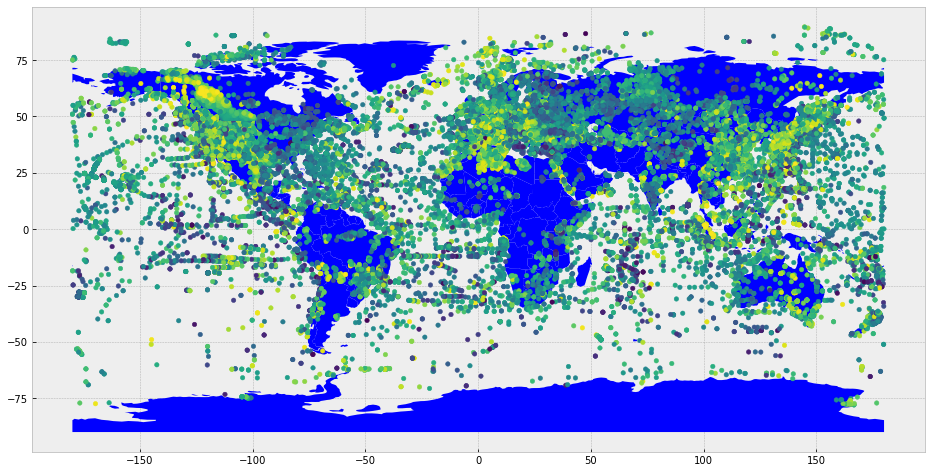

In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lng, df.lat))
fig, ax = plt.subplots(1, 1, figsize=(16, 13))
world.plot(ax=ax)
gdf.plot(ax=ax, column='q', s=20)
ax.set_axisbelow(True)
plt.show()

In [10]:
gdf.to_file(os.path.join(os.getcwd(), 'data', 'heatflow.geojson'), driver='GeoJSON')

c:\Users\s2216495\AppData\Local\Programs\Python\Python38\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


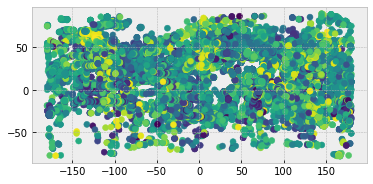

In [11]:
loaded = gpd.read_file(os.path.join(os.getcwd(), 'data', 'heatflow.geojson'))
loaded.plot(column='q')

In [125]:
from shapely.geometry import Polygon 
from itertools import product

x_vals = list(np.linspace(-180, 180, 720))
y_vals = list(np.linspace(-90, 90, 360))

geoms = [
    Polygon([[lower_x, lower_y],
             [lower_x, upper_y],
             [upper_x, upper_y],
             [upper_x, lower_y],
             ]) 
    for (lower_x, upper_x), (lower_y, upper_y) in 
    product(
        zip(x_vals[:-1], x_vals[1:]),
        zip(y_vals[:-1], y_vals[1:]))]

grid = gpd.GeoDataFrame({'geometry': geoms})


In [3]:
import os
import sys
from get_heatflow import get_heatflow

get_heatflow((-1.761873755588998, 54.9503096017342))

92.0

In [126]:
joined = grid.sjoin(gdf)

In [127]:
grid['q'] = np.ones(len(grid)) * (-1)

for i in range(len(grid)):

    grid.loc[i, 'q'] = joined.loc[joined['index_right'] == i]['q'].mean() 


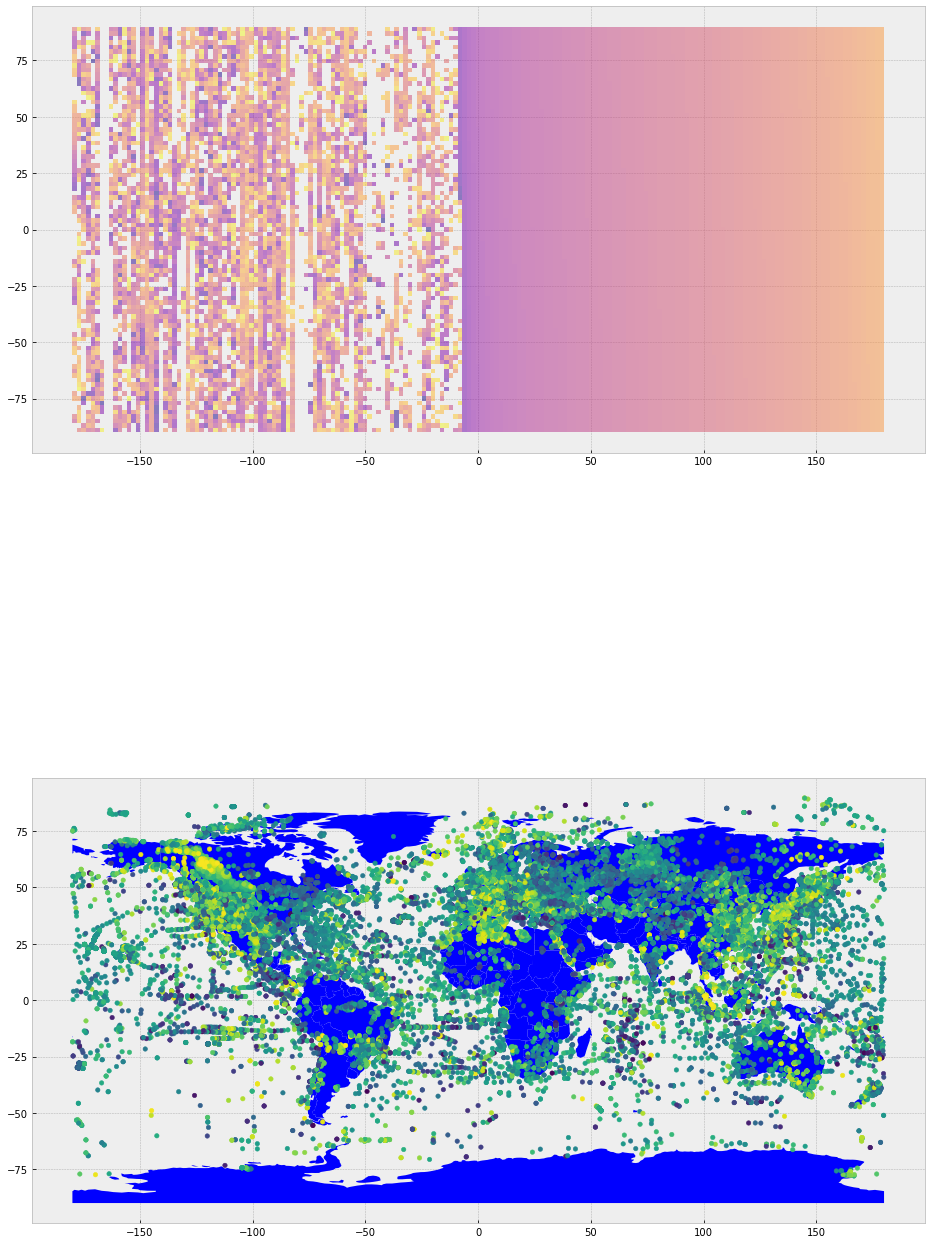

In [128]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lng, df.lat))
fig, axs = plt.subplots(2, 1, figsize=(16, 26))

grid.dropna().plot(ax=axs[0], column='q', alpha=0.5, cmap='plasma')

world.plot(ax=axs[1])
gdf.plot(ax=axs[1], column='q', s=20)

axs[0].set_axisbelow(True)
axs[1].set_axisbelow(True)
plt.show()



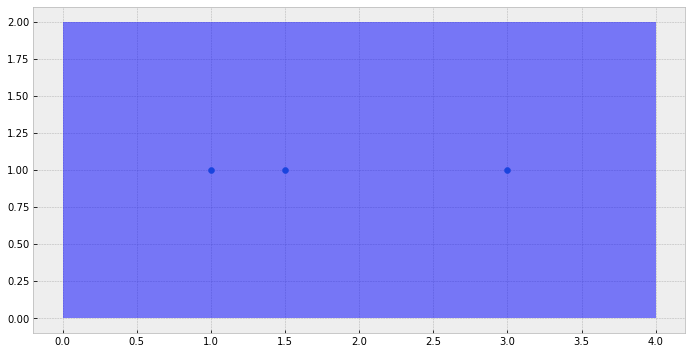

                                            geometry  values
0  POLYGON ((0.00000 0.00000, 2.00000 0.00000, 2....    -1.0
1  POLYGON ((2.00000 0.00000, 2.00000 2.00000, 4....    -1.0
   values                 geometry  index_right
0       1  POINT (1.00000 1.00000)            0
1       2  POINT (1.50000 1.00000)            0
2       4  POINT (3.00000 1.00000)            1


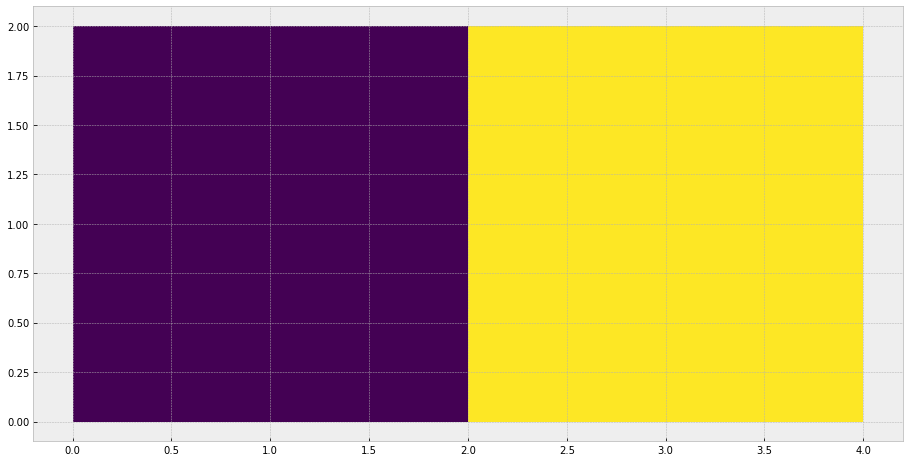

In [129]:
import rtree
from shapely.geometry import Point, Polygon

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

a = gpd.GeoDataFrame({
    'values': [1, 2, 4],
    'geometry': [
        Point([1., 1.]), 
        Point([1.5, 1.]),
        Point([3., 1.]) 
    ]}
)     

b = gpd.GeoDataFrame({
    'geometry': [
        Polygon([[0., 0.], [2., 0.], [2, 2], [0, 2]]), 
        Polygon([[2., 0.], [2., 2.], [4, 2], [4, 0]]), 
    ]}
)     
     
a.plot(ax=ax)
b.plot(ax=ax, alpha=0.5)

ax.set_axisbelow(True)
plt.show() 
    
# joined = b.sjoin(a)
joined = a.sjoin(b)

b['values'] = np.ones(len(b)) * (-1)

print(b.head())
print(joined.head())

for i in range(len(b)):

    b.loc[i, 'values'] = joined.loc[joined['index_right'] == i]['values'].mean() 




#joined['geometry'].value_counts()
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

b.plot(ax=ax, column='values')

plt.show()


